### BUILDING AN UNSUPERVISED LEARNING MODELS

\- Writen by Leonard Phillips

To begin building our unsupervised model, it is important to scale our features. Fortunately, we have already performed a Min-Max transformation our data.

Next must first find the number of clusters we would like to identify. We will test the model using 1 through 9 centroids and plot the result for a visual examination.

In [1]:
import pandas as pd

In [2]:
WHRData = pd.read_csv('cleanedWHRData.csv')
WHRData.drop(columns=['Unnamed: 0'],inplace=True)

To begin, we will need to extract all OECD countries into one dataframe for ease of workability

In [3]:
oecd_names = ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Czech Republic', 'Denmark', 'Estonia',
 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy',
 'Japan', 'South Korea', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal',
 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']

oecd_df = pd.DataFrame(columns=WHRData.columns)

for name in oecd_names:
    oecd_df = pd.concat([oecd_df,WHRData.loc[WHRData['Country name'] == name]],ignore_index=True)

#### Feature Scaling
Now that we have our workable OECD dataframe we will need to scale our prediction features in order to avoid a disproporational effect on the outcome which will lead to a degraded accuracy.
The method of I have used is MinMaxScaling.

In [4]:
from sklearn import preprocessing
for header in oecd_df.iloc[:, 2:].columns:
    minmax_scale = preprocessing.MinMaxScaler().fit(oecd_df[[header]].dropna())
    df_minmax_scale = minmax_scale.transform(oecd_df[[header]])
    oecd_df[[header]] = df_minmax_scale

#### Removing NaN values
Our K means clustering model can not handle NaN values, therefore, we must remove them. However .dropna() will delete the entire row. If we clear the X_train dataset of NaN values, it goes from having 217 rows to 1 row. This is a major issue. One solution to this problem is replacing the NaN values with the mean of the column. 

This will be an adequate solution for features that contain a small number of NaNs. Therefore, it is important to find what percentage of values in a feature are NaNs as we want to remove all features that contain more than 60% NaN values.

In [5]:
def percent_of_nan(df):
    percents = {}
    for column in df.columns:
        num_of_nans = df[column].isna().sum()
        total_rows = df[column].count() + num_of_nans
        percent_nan = (num_of_nans / total_rows)*100
        percents[df[column].name] = round(percent_nan, 2)
    return percents

In [6]:
from pprint import pprint

percentages = percent_of_nan(oecd_df)
dropped_columns = []
for key, value in percentages.items():
    if value > 40:
        dropped_columns.append(key)
        oecd_df.drop(key, axis=1, inplace=True)
print("Features deleted:")
pprint(dropped_columns)

Features deleted:
['GINI index (World Bank estimate)',
 'Most people can be trusted, Gallup',
 'Most people can be trusted, WVS round 1981-1984',
 'Most people can be trusted, WVS round 1989-1993',
 'Most people can be trusted, WVS round 1994-1998',
 'Most people can be trusted, WVS round 1999-2004',
 'Most people can be trusted, WVS round 2010-2014']


All NaN values must be replaced to satisfy our regression model. I will be using the mean of each column as a replacement.

In [7]:
oecd_df.fillna(oecd_df.mean(), inplace=True)

Text(0.5, 1.0, 'Within Cluster Sum of Squares versus number of Clusters')

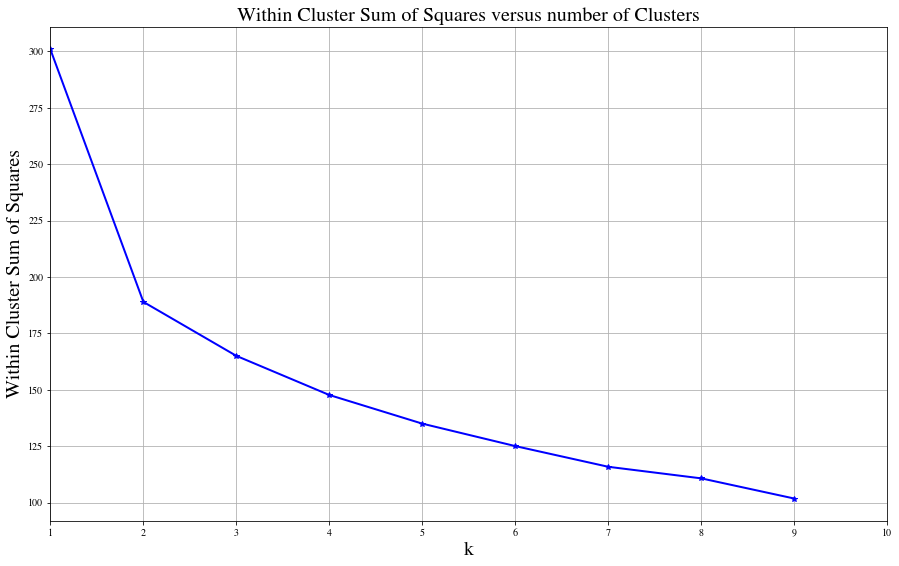

In [8]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

from pylab import rcParams

rcParams['figure.figsize'] = 14, 8
rcParams['font.size'] = 20
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
%matplotlib inline


k_rng = range(1,10)
est = [KMeans(n_clusters = k, init='random').fit(oecd_df.iloc[:,3:].values) for k in k_rng]

# Generally want to minimize WSS, while also minimizing k
within_cluster_sum_squares = [e.inertia_ for e in est]
fig, axes = plt.subplots()
fig.set_size_inches(15,20)

# Plot the results
plt.subplot(212)
plt.plot(k_rng, within_cluster_sum_squares, 'b*-')
plt.xlim([1,10])
plt.grid(True)
plt.xlabel('k', fontsize=20)
plt.ylabel('Within Cluster Sum of Squares', fontsize=20)
plt.title('Within Cluster Sum of Squares versus number of Clusters', fontsize=20)

After a visual examination of the plot above we can see that the clusters are becoming more cohesive as k increases. We can see the rate at which Sum of Squares is decreasing change when k=2. To find the best model we can start testing using k=2 until k=5 in our learning models.

Now that we know our range of k we want to calculate how well the clustering has performed. We can do this by producing a Silhouette Score for each model. The measure is between -1 (worst) and 1 (best). We also want to find a subset of features to use in our model. We can do this by looping over the clustering model, decreasing the number of features included with each iteration.

In [9]:
for i in range(3, 24):
    print(25-i, " features included")
    for k in range(2, 6):
        km = KMeans(n_clusters=k, init='random')
        km.fit(oecd_df.iloc[:,i:].values)
        predictions = km.predict(oecd_df.iloc[:,i:].values)

        print("k =",k, ": ", metrics.silhouette_score(oecd_df.iloc[:,i:].values, predictions))

22  features included
k = 2 :  0.3185852398565567
k = 3 :  0.26730116601015946
k = 4 :  0.19847727433257842
k = 5 :  0.20173420797160477
21  features included
k = 2 :  0.31212388523136153
k = 3 :  0.26770677711953067
k = 4 :  0.28490185708877097
k = 5 :  0.23380871339570278
20  features included
k = 2 :  0.3140409366308415
k = 3 :  0.26653750227750683
k = 4 :  0.23732480251015692
k = 5 :  0.27004442316897737
19  features included
k = 2 :  0.32449941420441003
k = 3 :  0.21763981264520904
k = 4 :  0.244975334935906
k = 5 :  0.23665411376615053
18  features included
k = 2 :  0.3220824238818169
k = 3 :  0.29963641105447425
k = 4 :  0.21053195056716437
k = 5 :  0.22491347400772602
17  features included
k = 2 :  0.30890297044268544
k = 3 :  0.1957297889452276
k = 4 :  0.2199922385444716
k = 5 :  0.23168362091370376
16  features included
k = 2 :  0.27558398949494817
k = 3 :  0.25881927695623835
k = 4 :  0.2820819663762267
k = 5 :  0.1987782327040021
15  features included
k = 2 :  0.2719117632

From the output, we can that when k was equal to 2, the model performed the best for all subset of features. We also see that as we decrease the number of variables, the accuracy of the clustering decreases up until four features. Here we see a sharp increase. This is to be expected we are reducing the number of data points meaning the chance of overlapping is reduced. This makes separating clusters easier.

Now that we know what parameters to use in the data we can start experimenting with feature subsets. I will be using the first four columns.

#### Final Model

In [10]:
feature_names = ['Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices']

In [11]:
km = KMeans(n_clusters=2, init='random')
km.fit(oecd_df[feature_names].values)
predictions = km.predict(oecd_df[feature_names].values)

print("k =",2, ": ", metrics.silhouette_score(oecd_df[feature_names].values, predictions))

k = 2 :  0.4818617914146042


In [12]:
for i in range(2):
    print("GROUP ", i )
    for r, val in oecd_df.iterrows():
        if i == predictions[r]:
            print(val[3])
#     print("\n")

GROUP  0
0.5136525635535119
0.5376752265019951
0.5463424305325368
0.5480887763974795
0.553720169410119
0.5648112348944467
0.569432078541853
0.5748355515637762
0.5795271648886651
0.5865656256065508
0.5884659995930743
0.596344850231068
0.56152825037063
0.5859313003355826
0.5721853312151
0.5860655545766909
0.5872780056688596
0.5842010857941844
0.5844399334556876
0.5842489593995399
0.5862081346622077
0.5980115802088433
0.607733564653044
0.5257801966668509
0.5501822059012547
0.5501286082778662
0.5430901475599823
0.545248102357931
0.5425661397274428
0.540990473672899
0.5467233379142824
0.5512926653994041
0.5561820175290242
0.5635862950356634
0.5698400449179317
0.5348652540137078
0.550496506527721
0.5500224537616427
0.5274396415307692
0.5379322869481458
0.549419350407212
0.552420817316924
0.5594878981249671
0.5689392926258519
0.569829117247143
0.5709510247813556
0.5806979867587847
0.5855561169718699
0.3824049930088922
0.3953267035328114
0.4169530843871163
0.4318079519099216
0.5874778259346929

From the cluster output above, we can see that there are two distince clusters of hgih and low values for 'Life Ladder'.

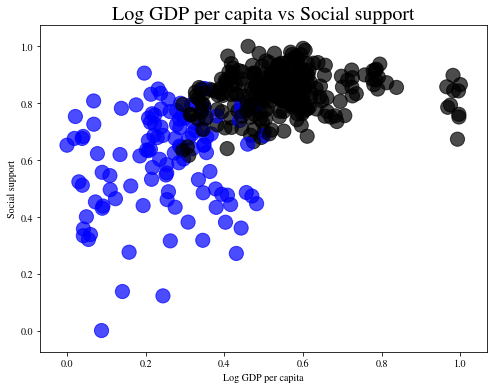

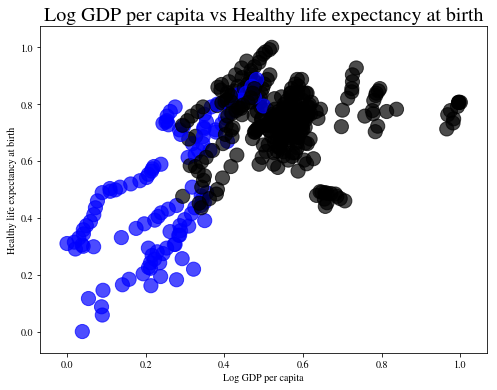

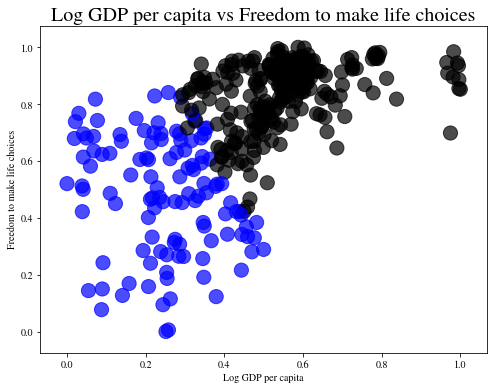

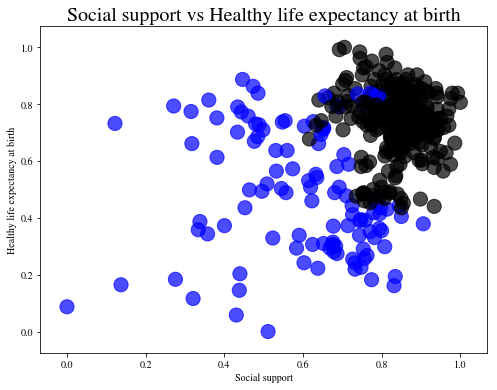

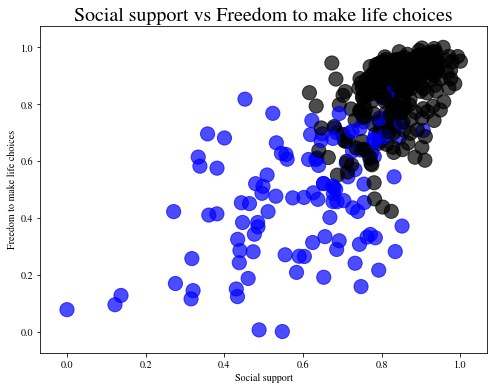

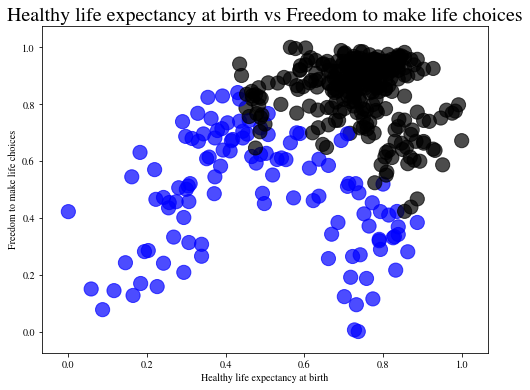

In [14]:
import numpy as np

container = []
for feature_i in feature_names:    
    for feature_j in feature_names:
        if feature_i != feature_j and feature_j not in container:
            colors = np.array(['black','blue'])
            plt.figure(figsize=(8, 6))
            plt.scatter(oecd_df.loc[:,feature_i], oecd_df.loc[:,feature_j], c = colors[predictions], alpha=0.7, s=200)
            plt.xlabel(feature_i)
            plt.ylabel(feature_j)
            title = feature_i + " vs " + feature_j
            plt.title(title, fontsize = 20)
    container.append(feature_i)

Log GDP per capita vs Social support graph shows that Log GDP per capita is more important in defining the clusters than Social support. 
This is the same for Log GDP per capita vs Healthy life expectancy at birth and Log GDP per capita vs Freedom to make life choices.

Social support vs Freedom to make life choices and Log GDP per capita vs Healthy life expectancy at birth has a lot of overlapping data points. The model had difficulty determining the clusters.